In [1]:
import importlib.util
import sys

module_name = 'micrograd'
module_path = r'C:\Users\Asus\Machine_learning\LLM\GPT\micrograd.py'

spec      = importlib.util.spec_from_file_location(module_name, module_path)
micrograd = importlib.util.module_from_spec(spec)
sys.modules[module_name] = micrograd
spec.loader.exec_module(micrograd)

In [2]:
Values = micrograd.Value

In [3]:
import random    

## Single Layer Perceptron

![](https://media.geeksforgeeks.org/wp-content/uploads/20221219111343/Single-Layer-Perceptron.png)

In [4]:
class Neuron:
    
    def __init__(self,n_inp):
        self.w = [Values(random.uniform(-1,1)) for _ in range(n_inp)] 
        self.b = Values(random.uniform(-1,1))
        
    def __call__(self,x):
        # weight * input + bias = (w*x + b)
        sum_neuron = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
        out        = sum_neuron.tanh()
        return out

In [5]:
neuron = Neuron(5)
x      = [Values(random.uniform(-1, 1)) for _ in range(3)] # 5 inputs feed into neuron
neuron(x) 

Value(data=0.714552942959814,grad=0.0)

In [6]:
# another neuron
neuron = Neuron(3)                                # n
inputs = [random.uniform(-1,1) for _ in range(5)] # x 

## Multi-layer-Perceptron

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*4PQOnabj78avPB2Mikk5GQ.jpeg)

In [7]:
class Neuron:
    def __init__(self,n_inp):
        self.w = [Values(random.uniform(-1,1)) for _ in range(n_inp)] 
        self.b = Values(random.uniform(-1,1))
        
    def __call__(self,x):
        # weight * input + bias = (w*x + b)
        sum_neuron = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
        out        = sum_neuron.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] 

class Layer:
    def __init__(self,n_inp,n_neuron):
        self.neuron = [Neuron(n_inp) for _ in range(n_neuron)] # number of neurons in each layers
    
    def __call__(self,x):
        out = [n(x) for n in self.neuron]  
        return out[0] if len(out) == 1 else out # return 0 index element from list if the len of out is 1, else return out itself
    
    def parameters(self):
        #params_ = [p for neuron in self.neuron for p in neuron.parameters()], this is list comprehension method
        params = []
        for neuron in self.neuron:
            ps = neuron.parameters()
            params.extend(ps) 
        return params
    
class MLP:
    def __init__(self,n_inp,n_out): 
        size        = [n_inp] + n_out                                        # eg: [3,4,4,1]
        self.layers = [Layer(size[i],size[i+1]) for i in range(len(n_out))]  # [Layer(3,4),Layer(4,4),Layer(4,1)]
        
    def __call__(self,x):
        for layer in self.layers:                                             
            x = layer(x)                 # x = layer(3,4)(x) ==> x = layer(4,4)(x) ==> x = layer(4,1) 
        return x 
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps) 
        return params
    
    def dict_parameter(self):
        dict_parameters = {}
        for layer_idx, layer in enumerate(self.layers):
            for neuron_idx, neuron in enumerate(layer.neuron):
                weights_key = f"Layer{layer_idx+1}_Neuron{neuron_idx+1}_weights"
                bias_key    = f"Layer{layer_idx+1}_Neuron{neuron_idx+1}_bias"
                
                # Add weights and bias to the dictionary
                dict_parameters[weights_key] = neuron.w 
                dict_parameters[bias_key] = neuron.b
                
        return dict_parameters

In [8]:
# binary model, ie output = 2

n = MLP(3,[4,4,2])      # [input, [hidden_1,hidden_2,output]]
x = [2.0,3.0,2.0]   # 3d input 
n(x) 

[Value(data=0.8206544679697237,grad=0.0),
 Value(data=0.8692911411063265,grad=0.0)]

In [88]:
n = MLP(3,[4,4,1])      # [input, [hidden_1,hidden_2,output]]
x = [2.0,3.0,2.0]   # 3d input 
n(x) 

Value(data=0.4276250469516422,grad=0.0)

## Trying dataset into Neural network 

In [89]:
x_data = [                 # 4 different samples with 3 input values 
    [2.0,3.0,-1.0],        # sample 1  
    [3.0,-1.0,0.5],        # sample 2
    [0.5,1.0,1.0],         # sample 3
    [1.0,1.0,-1.0]         # sample 4
]

y_data = [1.0,-1.0,-1.0,1.0]    # desired out put (ground truth value)
y_pred = [n(x) for x in x_data] # predicted value 
y_pred

[Value(data=-0.7800501835364235,grad=0.0),
 Value(data=-0.8557451945697723,grad=0.0),
 Value(data=0.2888404118300327,grad=0.0),
 Value(data=-0.7860313201869169,grad=0.0)]

These are the 4 output from the neural network. So we need to tune the weight and bias of NN with some techniques for achieving better result. 

The technique used in NN, for how well the model is performing is,we called as **loss function** 

In [74]:
## Mean square error loss 

square_error = [(y_out - y_ground)**2 for y_ground,y_out in zip(y_data,y_pred)] 
square_error

[Value(data=3.6750176932152443,grad=0.0),
 Value(data=0.18271781310860002,grad=0.0),
 Value(data=0.005592004222360807,grad=0.0),
 Value(data=3.4085681481715704,grad=0.0)]

In [75]:
loss = sum(square_error) / len(square_error)
loss

Value(data=1.8179739146794438,grad=0.0)

In [76]:
loss.backward()

In [77]:
n.layers[0].neuron[0].w

[Value(data=-0.5408103636915356,grad=0.4514341885407188),
 Value(data=0.4567483599362685,grad=0.6125308262872283),
 Value(data=0.19879872780121932,grad=-0.3496106665933597)]

The gradient of a weight in a neural network indicates 
- how the loss function changes with respect to that weight. Specifically,
    1. If the gradient of a weight is negative, it means that **increasing the weight will increase the loss,** and conversely, 
    2. **Decreasing the weight will reduce the loss**.
- This information is critical for the optimization process, particularly during the training of the neural network using gradient descent.

## Parameter update

#### W = W - learning_rate * d(loss) / dW
#### b  = b  - learning_rate * d(loss) / db

In [92]:
n.parameters()

[Value(data=-0.19435151517195148,grad=0.0),
 Value(data=-0.8312214098599391,grad=0.0),
 Value(data=0.7280744884306083,grad=0.0),
 Value(data=-0.7104649892189261,grad=0.0),
 Value(data=0.19750140681652373,grad=0.0),
 Value(data=0.1321115981763783,grad=0.0),
 Value(data=-0.3957555640152912,grad=0.0),
 Value(data=-0.491194655173653,grad=0.0),
 Value(data=0.3530032272509007,grad=0.0),
 Value(data=-0.7781310975223048,grad=0.0),
 Value(data=0.4063672280936226,grad=0.0),
 Value(data=0.032254945775817,grad=0.0),
 Value(data=0.563679080456194,grad=0.0),
 Value(data=-0.23079398351710156,grad=0.0),
 Value(data=-0.7500319301499174,grad=0.0),
 Value(data=-0.15972609818154182,grad=0.0),
 Value(data=-0.6601726913635424,grad=0.0),
 Value(data=-0.21520050314281214,grad=0.0),
 Value(data=0.4702082454269507,grad=0.0),
 Value(data=0.6977550085589566,grad=0.0),
 Value(data=-0.3216309585646835,grad=0.0),
 Value(data=-0.30599143115116,grad=0.0),
 Value(data=0.3127168443037831,grad=0.0),
 Value(data=0.1475872

In [93]:
iter_loss = []
for i in range(60):
    
    # prediction 
    y_pred       = [n(x) for x in x_data]
    
    # loss 
    squared_loss = [(y_out - y_ground)**2 for y_out,y_ground in zip(y_pred,y_data)]
    loss         = sum(squared_loss) / len(squared_loss)
    
    # back propagation
    loss.backward()
    
    # update the weight and bias
    for para in n.parameters():
        para.data += - 0.01 * para.grad 
    iter_loss.append((i,loss.data)) 

In [94]:
n.parameters()

[Value(data=0.5068226635912012,grad=-1.5582191338182656),
 Value(data=-1.273707785650377,grad=0.9130902973992112),
 Value(data=0.6881691623306353,grad=0.027438318132001663),
 Value(data=-0.6251113065383268,grad=-0.24071834705187653),
 Value(data=-1.916258477527606,grad=3.9441210284906165),
 Value(data=2.277874836420132,grad=-4.950379030683242),
 Value(data=-1.4288934242058233,grad=3.0476288562762193),
 Value(data=-0.5064029710352965,grad=-0.35021218100854334),
 Value(data=0.26258807187791655,grad=0.4099320443642954),
 Value(data=-0.36428055531509285,grad=-0.47092555792835283),
 Value(data=2.63211621648376,grad=-4.330321210005597),
 Value(data=0.6414469076332935,grad=-0.852037387341666),
 Value(data=-0.8622991028554826,grad=2.451136677491643),
 Value(data=-0.4222165182394307,grad=-0.21371302416907523),
 Value(data=0.052181630163832905,grad=-0.8194405835641807),
 Value(data=-0.2459608496687267,grad=-0.1414975142821083),
 Value(data=0.40958622286826246,grad=-1.980711203533637),
 Value(dat

In [87]:
y_pred = [n(x) for x in x_data] # predicted value 
y_pred

[Value(data=0.9998626718887925,grad=0.0),
 Value(data=-0.9999129166616457,grad=0.0),
 Value(data=-0.9998135034260061,grad=0.0),
 Value(data=0.9998758924525871,grad=0.0)]

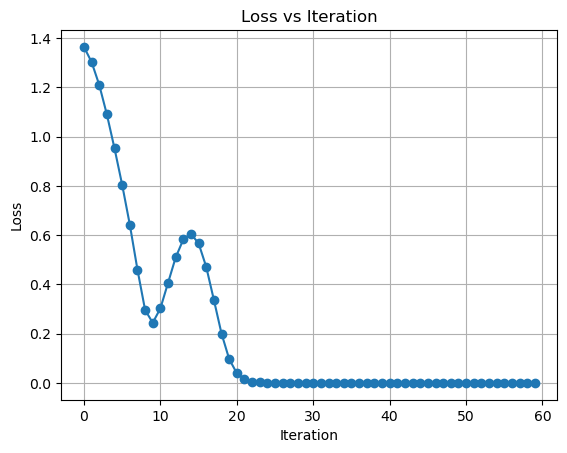

In [16]:
import matplotlib.pyplot as plt 

iterations, loss_values = zip(*iter_loss)

# Plot the data
plt.plot(iterations, loss_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.grid(True)
plt.show()

In [41]:
y_pred = [n(x) for x in x_data] # predicted value 
y_pred

[Value(data=-0.048038261402618174,grad=0.0),
 Value(data=-0.7650636553699113,grad=0.0),
 Value(data=-0.7947833475614652,grad=0.0),
 Value(data=-0.37525007510653613,grad=0.0)]

Did anyone notice any glitch in the code, There is a common glitch in the code, that is **zero_grad** 

- We have to zero grad before doing each and every backpropagation, ie if you dont zeroing in each propagation, gradient accumulate by default.<br>.

- **Prevent Gradient Accumulation:** In many deep learning frameworks, gradients are accumulated by default. This means that if you perform multiple backward passes without zeroing out the gradients, the gradients will add up, which will result in incorrect updates. By zeroing the gradients before each backward pass, you ensure that only the gradients from the current batch or iteration are considered.<br>.

- **Ensure Accurate Updates:** Each iteration of backpropagation calculates the gradient of the loss with respect to the model parameters. If the gradients are not zeroed out, the accumulated gradients from previous iterations will interfere, leading to incorrect parameter updates.<br>.
 
- **Maintain Stability:** Accumulated gradients can become very large, leading to unstable training and exploding gradients. Zeroing the gradients helps maintain the stability of the training process.<br>.

In [18]:
iter_loss = []
for i in range(10000):
    
    # prediction 
    y_pred       = [n(x) for x in x_data]
    
    # loss 
    squared_loss = [(y_out - y_ground)**2 for y_out,y_ground in zip(y_pred,y_data)]
    loss         = sum(squared_loss) / len(squared_loss)
    
    # back propagation
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update the weight and bias
    for para in n.parameters():
        para.data += - 0.01 * para.grad 
    iter_loss.append((i,loss.data)) 

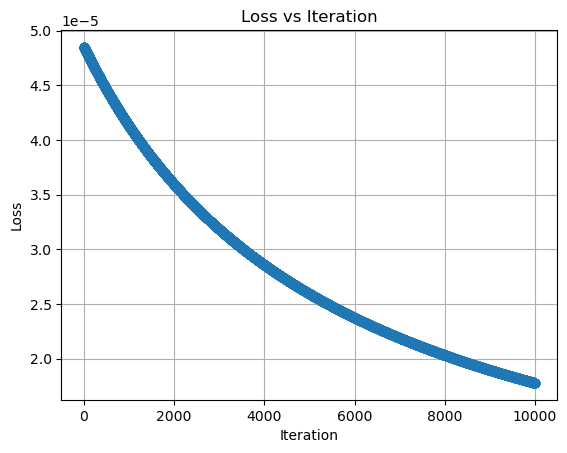

In [19]:
import matplotlib.pyplot as plt 

iterations, loss_values = zip(*iter_loss)

# Plot the data
plt.plot(iterations, loss_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.grid(True)
plt.show()

In [69]:
class Neuron:
    def __init__(self,n_inp):
        self.w = [Values(random.uniform(-1,1)) for _ in range(n_inp)] 
        self.b = Values(random.uniform(-1,1))
        
    def __call__(self,x):
        # weight * input + bias = (w*x + b)
        sum_neuron = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
        out        = sum_neuron.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b] 

class Layer:
    def __init__(self,n_inp,n_neuron):
        self.neuron = [Neuron(n_inp) for _ in range(n_neuron)] # number of neurons in each layers
    
    def __call__(self,x):
        out = [n(x) for n in self.neuron]  
        return out[0] if len(out) == 1 else out # return 0 index element from list if the len of out is 1, else return out itself
    
    def parameters(self):
        #params_ = [p for neuron in self.neuron for p in neuron.parameters()], this is list comprehension method
        params = []
        for neuron in self.neuron:
            ps = neuron.parameters()
            params.extend(ps) 
        return params
    
class MLP:
    def __init__(self,n_inp,n_out): 
        size        = [n_inp] + n_out                                        # eg: [3,4,4,1]
        self.layers = [Layer(size[i],size[i+1]) for i in range(len(n_out))]  # [Layer(3,4),Layer(4,4),Layer(4,1)]
        
    def __call__(self,x):
        for layer in self.layers:                                             
            x = layer(x)                 # x = layer(3,4)(x) ==> x = layer(4,4)(x) ==> x = layer(4,1) 
        return x 
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps) 
        return params
    
    def backward(self,x_data=[],y_data = [],learning_rate = 0.01,iteration=5000,plot_loss=False):
        
        iter_loss = []
        for i in range(iteration): 
            y_pred       = [self(x) for x in x_data]
            # loss 
            square_error = [(y_out - y_data)**2 for y_out,y_data in zip(y_pred,y_data)]
            loss         = sum(square_error) / len(square_error) 
            
            # backward propagation
            for p in self.parameters():
                p.grad = 0.0        
            loss.backward()
            # parameter update 
            for p in self.parameters():
                p.data += -learning_rate * para.grad  
            

In [70]:
n = MLP(3,[4,4,1])      # [input, [hidden_1,hidden_2,output]]
x = [2.0,3.0,2.0]   # 3d input 
n(x) 

Value(data=-0.9515243633888845,grad=0.0)

In [71]:
n.parameters()

[Value(data=-0.537346361807312,grad=0.0),
 Value(data=0.4602123618204921,grad=0.0),
 Value(data=0.20226272968558168,grad=0.0),
 Value(data=-0.22033670895213286,grad=0.0),
 Value(data=0.7031764571636985,grad=0.0),
 Value(data=0.5469821701407171,grad=0.0),
 Value(data=-0.11373053056845328,grad=0.0),
 Value(data=0.6707229699590251,grad=0.0),
 Value(data=-0.492626262535935,grad=0.0),
 Value(data=0.39279883812016547,grad=0.0),
 Value(data=-0.002834963676115354,grad=0.0),
 Value(data=0.08672598231057904,grad=0.0),
 Value(data=0.6854951158986833,grad=0.0),
 Value(data=-0.1331914239045906,grad=0.0),
 Value(data=0.09414752849783103,grad=0.0),
 Value(data=0.7202187013960681,grad=0.0),
 Value(data=-0.5201476617833516,grad=0.0),
 Value(data=-0.03203872045374401,grad=0.0),
 Value(data=-0.42312418230830073,grad=0.0),
 Value(data=-0.7370716043592029,grad=0.0),
 Value(data=-0.10500265722503643,grad=0.0),
 Value(data=0.2579268841119371,grad=0.0),
 Value(data=0.23304923862103943,grad=0.0),
 Value(data=0

In [72]:
a = n.backward(x_data=x_data,y_data=y_data)

-0.9105375551534267
-0.9105382479538036
-0.9105389407541804
-0.9105396335545572
-0.9105403263549341
-0.9105410191553109
-0.9105417119556878
-0.9105424047560646
-0.9105430975564415
-0.9105437903568183
-0.9105444831571952
-0.910545175957572
-0.9105458687579489
-0.9105465615583257
-0.9105472543587025
-0.9105479471590794
-0.9105486399594562
-0.9105493327598331
-0.9105500255602099
-0.9105507183605868
-0.9105514111609636
-0.9105521039613405
-0.9105527967617173
-0.9105534895620941
-0.910554182362471
-0.9105548751628478
-0.9105555679632247
-0.9105562607636015
-0.9105569535639784
-0.9105576463643552
-0.9105583391647321
-0.9105590319651089
-0.9105597247654857
-0.9105604175658626
-0.9105611103662394
-0.9105618031666163
-0.9105624959669931
-0.91056318876737
-0.9105638815677468
-0.9105645743681237
-0.9105652671685005
-0.9105659599688773
-0.9105666527692542
-0.910567345569631
-0.9105680383700079
-0.9105687311703847
-0.9105694239707616
-0.9105701167711384
-0.9105708095715153
-0.9105715023718921
-0.91

-0.9108319953135857
-0.9108326881139626
-0.9108333809143394
-0.9108340737147163
-0.9108347665150931
-0.9108354593154699
-0.9108361521158468
-0.9108368449162236
-0.9108375377166005
-0.9108382305169773
-0.9108389233173542
-0.910839616117731
-0.9108403089181079
-0.9108410017184847
-0.9108416945188615
-0.9108423873192384
-0.9108430801196152
-0.9108437729199921
-0.9108444657203689
-0.9108451585207458
-0.9108458513211226
-0.9108465441214995
-0.9108472369218763
-0.9108479297222531
-0.91084862252263
-0.9108493153230068
-0.9108500081233837
-0.9108507009237605
-0.9108513937241374
-0.9108520865245142
-0.9108527793248911
-0.9108534721252679
-0.9108541649256447
-0.9108548577260216
-0.9108555505263984
-0.9108562433267753
-0.9108569361271521
-0.910857628927529
-0.9108583217279058
-0.9108590145282827
-0.9108597073286595
-0.9108604001290364
-0.9108610929294132
-0.91086178572979
-0.9108624785301669
-0.9108631713305437
-0.9108638641309206
-0.9108645569312974
-0.9108652497316743
-0.9108659425320511
-0.910

-0.911227584328764
-0.9112282771291409
-0.9112289699295177
-0.9112296627298946
-0.9112303555302714
-0.9112310483306483
-0.9112317411310251
-0.911232433931402
-0.9112331267317788
-0.9112338195321557
-0.9112345123325325
-0.9112352051329093
-0.9112358979332862
-0.911236590733663
-0.9112372835340399
-0.9112379763344167
-0.9112386691347936
-0.9112393619351704
-0.9112400547355473
-0.9112407475359241
-0.911241440336301
-0.9112421331366778
-0.9112428259370546
-0.9112435187374315
-0.9112442115378083
-0.9112449043381852
-0.911245597138562
-0.9112462899389389
-0.9112469827393157
-0.9112476755396925
-0.9112483683400694
-0.9112490611404462
-0.9112497539408231
-0.9112504467411999
-0.9112511395415768
-0.9112518323419536
-0.9112525251423305
-0.9112532179427073
-0.9112539107430842
-0.911254603543461
-0.9112552963438378
-0.9112559891442147
-0.9112566819445915
-0.9112573747449684
-0.9112580675453452
-0.9112587603457221
-0.9112594531460989
-0.9112601459464758
-0.9112608387468526
-0.9112615315472294
-0.911

-0.9115171748862851
-0.911517867686662
-0.9115185604870388
-0.9115192532874157
-0.9115199460877925
-0.9115206388881694
-0.9115213316885462
-0.911522024488923
-0.9115227172892999
-0.9115234100896767
-0.9115241028900536
-0.9115247956904304
-0.9115254884908073
-0.9115261812911841
-0.911526874091561
-0.9115275668919378
-0.9115282596923147
-0.9115289524926915
-0.9115296452930683
-0.9115303380934452
-0.911531030893822
-0.9115317236941989
-0.9115324164945757
-0.9115331092949526
-0.9115338020953294
-0.9115344948957063
-0.9115351876960831
-0.91153588049646
-0.9115365732968368
-0.9115372660972136
-0.9115379588975905
-0.9115386516979673
-0.9115393444983442
-0.911540037298721
-0.9115407300990979
-0.9115414228994747
-0.9115421156998516
-0.9115428085002284
-0.9115435013006052
-0.9115441941009821
-0.9115448869013589
-0.9115455797017358
-0.9115462725021126
-0.9115469653024895
-0.9115476581028663
-0.9115483509032432
-0.91154904370362
-0.9115497365039968
-0.9115504293043737
-0.9115511221047505
-0.911551

-0.9118455622649095
-0.9118462550652864
-0.9118469478656632
-0.9118476406660401
-0.9118483334664169
-0.9118490262667938
-0.9118497190671706
-0.9118504118675475
-0.9118511046679243
-0.9118517974683011
-0.911852490268678
-0.9118531830690548
-0.9118538758694317
-0.9118545686698085
-0.9118552614701854
-0.9118559542705622
-0.911856647070939
-0.9118573398713159
-0.9118580326716927
-0.9118587254720696
-0.9118594182724464
-0.9118601110728233
-0.9118608038732001
-0.911861496673577
-0.9118621894739538
-0.9118628822743307
-0.9118635750747075
-0.9118642678750843
-0.9118649606754612
-0.911865653475838
-0.9118663462762149
-0.9118670390765917
-0.9118677318769686
-0.9118684246773454
-0.9118691174777223
-0.9118698102780991
-0.911870503078476
-0.9118711958788528
-0.9118718886792296
-0.9118725814796065
-0.9118732742799833
-0.9118739670803602
-0.911874659880737
-0.9118753526811139
-0.9118760454814907
-0.9118767382818675
-0.9118774310822444
-0.9118781238826212
-0.9118788166829981
-0.9118795094833749
-0.911

-0.9122196744684057
-0.9122203672687825
-0.9122210600691594
-0.9122217528695362
-0.9122224456699131
-0.9122231384702899
-0.9122238312706668
-0.9122245240710436
-0.9122252168714204
-0.9122259096717973
-0.9122266024721741
-0.912227295272551
-0.9122279880729278
-0.9122286808733047
-0.9122293736736815
-0.9122300664740584
-0.9122307592744352
-0.912231452074812
-0.9122321448751889
-0.9122328376755657
-0.9122335304759426
-0.9122342232763194
-0.9122349160766963
-0.9122356088770731
-0.91223630167745
-0.9122369944778268
-0.9122376872782036
-0.9122383800785805
-0.9122390728789573
-0.9122397656793342
-0.912240458479711
-0.9122411512800879
-0.9122418440804647
-0.9122425368808416
-0.9122432296812184
-0.9122439224815952
-0.9122446152819721
-0.9122453080823489
-0.9122460008827258
-0.9122466936831026
-0.9122473864834795
-0.9122480792838563
-0.9122487720842332
-0.91224946488461
-0.9122501576849869
-0.9122508504853637
-0.9122515432857405
-0.9122522360861174
-0.9122529288864942
-0.9122536216868711
-0.9122

-0.9126131850824535
-0.9126138778828303
-0.9126145706832072
-0.912615263483584
-0.9126159562839609
-0.9126166490843377
-0.9126173418847146
-0.9126180346850914
-0.9126187274854682
-0.9126194202858451
-0.9126201130862219
-0.9126208058865988
-0.9126214986869756
-0.9126221914873525
-0.9126228842877293
-0.9126235770881062
-0.912624269888483
-0.9126249626888598
-0.9126256554892367
-0.9126263482896135
-0.9126270410899904
-0.9126277338903672
-0.9126284266907441
-0.9126291194911209
-0.9126298122914978
-0.9126305050918746
-0.9126311978922514
-0.9126318906926283
-0.9126325834930051
-0.912633276293382
-0.9126339690937588
-0.9126346618941357
-0.9126353546945125
-0.9126360474948894
-0.9126367402952662
-0.912637433095643
-0.9126381258960199
-0.9126388186963967
-0.9126395114967736
-0.9126402042971504
-0.9126408970975273
-0.9126415898979041
-0.912642282698281
-0.9126429754986578
-0.9126436682990346
-0.9126443610994115
-0.9126450538997883
-0.9126457467001652
-0.912646439500542
-0.9126471323009189
-0.912

-0.912967898875398
-0.9129685916757748
-0.9129692844761517
-0.9129699772765285
-0.9129706700769054
-0.9129713628772822
-0.912972055677659
-0.9129727484780359
-0.9129734412784127
-0.9129741340787896
-0.9129748268791664
-0.9129755196795433
-0.9129762124799201
-0.912976905280297
-0.9129775980806738
-0.9129782908810506
-0.9129789836814275
-0.9129796764818043
-0.9129803692821812
-0.912981062082558
-0.9129817548829349
-0.9129824476833117
-0.9129831404836886
-0.9129838332840654
-0.9129845260844422
-0.9129852188848191
-0.9129859116851959
-0.9129866044855728
-0.9129872972859496
-0.9129879900863265
-0.9129886828867033
-0.9129893756870802
-0.912990068487457
-0.9129907612878339
-0.9129914540882107
-0.9129921468885875
-0.9129928396889644
-0.9129935324893412
-0.9129942252897181
-0.9129949180900949
-0.9129956108904718
-0.9129963036908486
-0.9129969964912255
-0.9129976892916023
-0.9129983820919791
-0.912999074892356
-0.9129997676927328
-0.9130004604931097
-0.9130011532934865
-0.9130018460938634
-0.913

-0.9133752654969827
-0.9133759582973595
-0.9133766510977364
-0.9133773438981132
-0.91337803669849
-0.9133787294988669
-0.9133794222992437
-0.9133801150996206
-0.9133808078999974
-0.9133815007003743
-0.9133821935007511
-0.913382886301128
-0.9133835791015048
-0.9133842719018817
-0.9133849647022585
-0.9133856575026353
-0.9133863503030122
-0.913387043103389
-0.9133877359037659
-0.9133884287041427
-0.9133891215045196
-0.9133898143048964
-0.9133905071052733
-0.9133911999056501
-0.9133918927060269
-0.9133925855064038
-0.9133932783067806
-0.9133939711071575
-0.9133946639075343
-0.9133953567079112
-0.913396049508288
-0.9133967423086649
-0.9133974351090417
-0.9133981279094185
-0.9133988207097954
-0.9133995135101722
-0.9134002063105491
-0.9134008991109259
-0.9134015919113028
-0.9134022847116796
-0.9134029775120565
-0.9134036703124333
-0.9134043631128101
-0.913405055913187
-0.9134057487135638
-0.9134064415139407
-0.9134071343143175
-0.9134078271146944
-0.9134085199150712
-0.9134092127154481
-0.913

-0.9137001888737228
-0.9137008816740997
-0.9137015744744765
-0.9137022672748534
-0.9137029600752302
-0.9137036528756071
-0.9137043456759839
-0.9137050384763608
-0.9137057312767376
-0.9137064240771144
-0.9137071168774913
-0.9137078096778681
-0.913708502478245
-0.9137091952786218
-0.9137098880789987
-0.9137105808793755
-0.9137112736797524
-0.9137119664801292
-0.913712659280506
-0.9137133520808829
-0.9137140448812597
-0.9137147376816366
-0.9137154304820134
-0.9137161232823903
-0.9137168160827671
-0.913717508883144
-0.9137182016835208
-0.9137188944838976
-0.9137195872842745
-0.9137202800846513
-0.9137209728850282
-0.913721665685405
-0.9137223584857819
-0.9137230512861587
-0.9137237440865356
-0.9137244368869124
-0.9137251296872893
-0.9137258224876661
-0.9137265152880429
-0.9137272080884198
-0.9137279008887966
-0.9137285936891735
-0.9137292864895503
-0.9137299792899272
-0.913730672090304
-0.9137313648906809
-0.9137320576910577
-0.9137327504914345
-0.9137334432918114
-0.9137341360921882
-0.91

In [53]:
a

[Value(data=0.6943203715884766,grad=0.0),
 Value(data=0.7182192020307929,grad=0.0),
 Value(data=0.8409699342807054,grad=0.0),
 Value(data=0.8253042634062662,grad=0.0)]

In [55]:
[n(x) for x in x_data] 

[Value(data=0.6943203715884766,grad=0.0),
 Value(data=0.7182192020307929,grad=0.0),
 Value(data=0.8409699342807054,grad=0.0),
 Value(data=0.8253042634062662,grad=0.0)]

In [56]:
n.parameters()

[Value(data=-0.276320450039631,grad=0.711785994424014),
 Value(data=0.10741067866656373,grad=-0.23425149781656973),
 Value(data=0.11918001914895793,grad=0.2970510653465419),
 Value(data=0.4818293446989894,grad=0.31768110412445466),
 Value(data=0.1146915026986558,grad=0.22478187580760917),
 Value(data=-0.5690229835398328,grad=-0.06823584692018757),
 Value(data=-0.46408900456148294,grad=0.09542117722561069),
 Value(data=0.21483563700995667,grad=0.09863826487977953),
 Value(data=0.8416075687052276,grad=-0.014942704418076509),
 Value(data=-0.14602928483087219,grad=-0.023561752038982222),
 Value(data=-0.5158053075133435,grad=-0.034477806456882906),
 Value(data=0.18541252486782378,grad=-0.029305998283666413),
 Value(data=-0.25635451066037995,grad=-0.00607423210722036),
 Value(data=0.19848105312292597,grad=-0.0198669857093038),
 Value(data=-0.36018616166910955,grad=0.03568136020456156),
 Value(data=-0.09951511304441663,grad=0.009881179761655888),
 Value(data=0.18274019687620413,grad=-0.000636

In [23]:
class Neuron:
    """Neuron class represent a single neuron in a neural network"""
    def __init__(self,n_inp):
        self.w = [Values(random.uniform(-1,1)) for _ in range(n_inp)] 
        self.b = Values(random.uniform(-1,1))
        """
            Initialize the Neuron object.

            Args:
                n_inp (int): Number of inputs to the neuron.
            """
    def __call__(self,x):
        """
        Compute the output of the neuron for a given input.

        Args:
            x (list of Values): Input vector to the neuron.

        Returns:
            Values: The output after applying the tanh activation function.
        """
        # weight * input + bias = (w*x + b)
        sum_neuron = sum((wi * xi for wi,xi in zip(self.w,x)),self.b)
        out        = sum_neuron.tanh()
        return out

class Layer:
    """Layer class representing a layer layer of neurons in a neural network"""
    def __init__(self,n_inp,n_neuron):
        """
        Initialize the Layer object.
        
        Args:
            n_inp (int): Number of inputs to each neuron in the layer.
            n_neuron (int): Number of neurons in the layer.
        """
        if not isinstance(n_inp, int) or not isinstance(n_neuron, int):
            raise TypeError("n_inp and n_neuron must be integers.")
            
        self.neuron = [Neuron(n_inp) for _ in range(n_neuron)] #number of neurons in each layers
    
    def __call__(self,x):
        out = [n(x) for n in self.neuron]  
        return out 